In [1]:
import torch
device = torch.device('cpu')
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from IPython import display

from envs import CollectData
from datahandler import ShuffleDataset

from models import SinkhornNet, forward, backward, ll

In [2]:
K = 4 # Number of targets
d = 2 # Target state dimensionality
patch_dim = 10 # patch size of window around detections
l = 50 # subsequence length
batch_size = 8 #batch size for training updates
epochs = 4

In [3]:
# Define a sinkhorn net for data association and optimizer
sn = SinkhornNet(latent_dim=8, K=4, d=2, n_samples=1, noise_factor=1.0, temp=1.0, n_iters=25, sigQ=5)
optimizer = torch.optim.Adam(sn.parameters(),lr=1e-3)

In [4]:
# Collect some training data (100 motion sequences, 100 steps long)
dg = CollectData(K=4)

In [5]:
losses = []
loss_bb = []
batch_losses = []

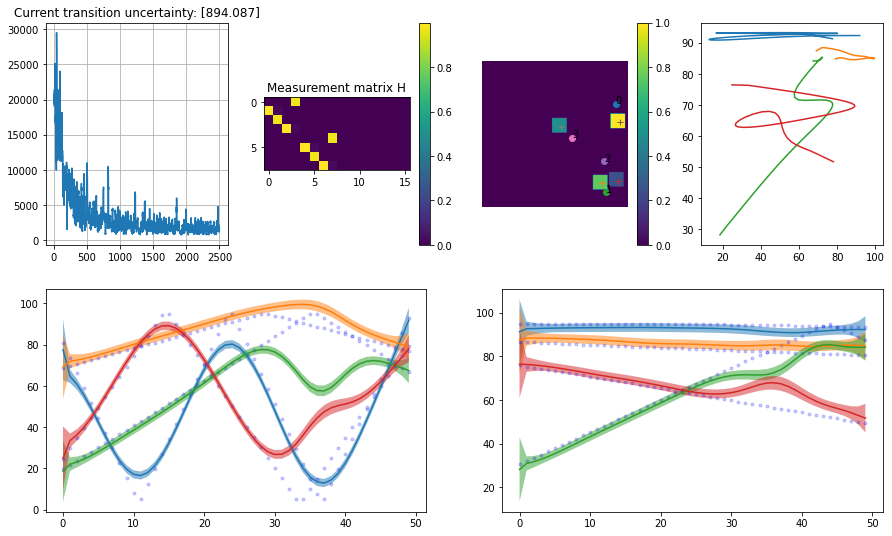

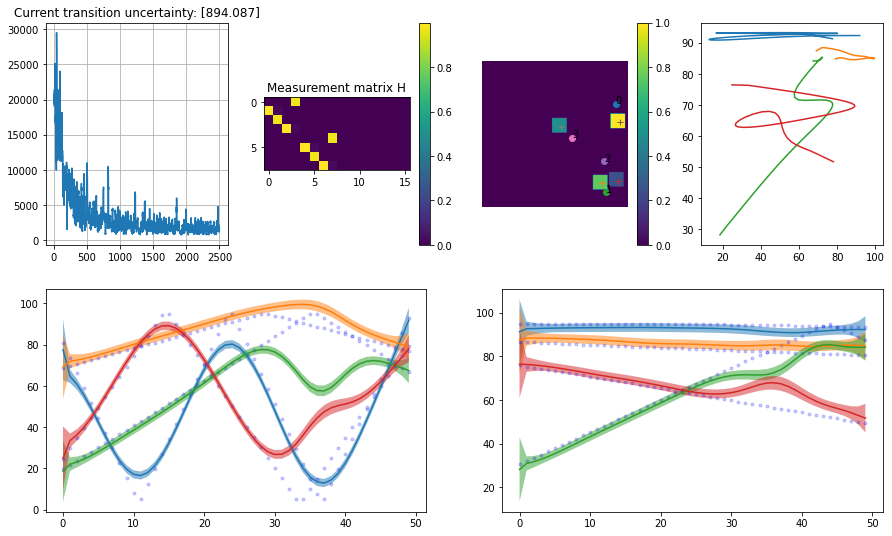

In [6]:
# Training loop
plt.figure(figsize=(15,9))
    
# Initialise with high uncertainty
state_init = torch.zeros(K*2*2,1)
cov_init = 300*torch.eye(K*2*2)

# Repeat over multiple epochs
for epoch in range(epochs):
    
    for n in range(len(dg.ims)):

        #Sample a new training sequence task
        dset = ShuffleDataset(dg.ims[n],dg.positions[n],l=l,K=K,d=patch_dim)
        sampler = DataLoader(dset, batch_size=1, shuffle=True)

        #Train for 1 epoch on a subsequence drawn from this
        for ims_batch, patches_batch, meas_batch, _ in sampler:

                meas_batch = torch.transpose(torch.squeeze(meas_batch),1,2).reshape(l,-1)

                batch_losses_b = []

                # Predict permutations
                Ps,latents = sn(patches_batch.reshape(-1,K,2*patch_dim,2*patch_dim),meas_batch)
                loss_b = []

                for P in Ps:

                    # Get covariance params
                    sigR = 5.0
                    sigQ = torch.exp(sn.logSigQ)

                    # Forward-Backward RTS
                    state,cov,state_pred,cov_pred,H_list = forward(P,meas_batch,state_init,cov_init,k=K,d=2,sigR=sigR,sigQ=sigQ)
                    state,cov = backward(state,cov,state_pred,cov_pred,k=K,d=2)

                    # Marginal Likelihood
                    cov_z = [torch.matmul(torch.matmul(H_list[i],cov[i+1]),H_list[i].T) for i in range(len(H_list))]
                    z_x = [torch.matmul(H_list[i],state[i+1]) for i in range(len(H_list))]
                    lls = [ll(z_x[i],cov_z[i],torch.squeeze(meas_batch)[i],sigR=sigR) for i in range(len(H_list))]

                    #Append losses
                    loss_b.append(torch.sum(-torch.stack(lls)))
                    batch_losses_b.append(loss_b[-1].item())

                loss_bb.append(torch.mean(torch.stack(loss_b)))
                batch_losses.append(np.mean(batch_losses_b))

                # Step after batch size updates
                if len(loss_bb) >= batch_size:
                    loss = torch.mean(torch.stack(loss_bb))
                    loss.backward()
                    optimizer.step()

                    optimizer.zero_grad()
                    losses.append(np.mean(batch_losses))

                    loss_bb = []
                    batch_losses = []
                    
                    # Some fancy plotting to visualise learning
                    plt.clf()
                    plt.subplot(2,4,1)

                    plt.plot(losses)
                    plt.title('Current transition uncertainty: '+str(sigQ.detach().numpy()))
                    plt.grid()

                    plt.subplot(2,4,2)
                    plt.imshow(H_list[-1].detach().numpy())
                    plt.colorbar()
                    plt.title('Measurement matrix H')

                    plt.subplot(2,4,3)
                    idx = np.random.randint(l)
                    im = torch.squeeze(ims_batch)[idx]
                    plt.imshow(im)
                    plt.colorbar()
                    s = state[idx].detach().numpy()[:,0:2*K]

                    for j in range(K):
                        plt.plot((s[j+K]),(s[j]),'o')
                        plt.text((s[j+K]),(s[j]),str(j))
                        plt.plot((meas_batch[idx][j+K]),(meas_batch[idx][j]),'+')

                    plt.axis('off')

                    xp = torch.squeeze(torch.stack(state[1:])).detach().numpy()[:,0:K]
                    yp = torch.squeeze(torch.stack(state[1:])).detach().numpy()[:,K:2*K]

                    plt.subplot(2,4,4)
                    for j in range(K):
                        plt.plot(xp[:,j],yp[:,j])


                    sd = np.vstack([np.diag(cv.detach().numpy()) for cv in cov]) 

                    plt.subplot(2,2,3)
                    plt.plot(meas_batch[:,0:K].numpy(),'b.',alpha=0.2)

                    plt.plot(xp)
                    for j in range(K):
                        plt.fill_between(np.arange(xp.shape[0]),xp[:,j]-3*sd[1:,j],xp[:,j]+3*sd[1:,j],alpha=0.5)

                    plt.subplot(2,2,4)
                    plt.plot(meas_batch[:,K:].numpy(),'b.',alpha=0.2)

                    plt.plot(yp)
                    for j in range(K):
                        plt.fill_between(np.arange(yp.shape[0]),yp[:,j]-3*sd[1:,j+K],yp[:,j]+3*sd[1:,j+K],alpha=0.5)

                    display.clear_output(wait=True)
                    display.display(plt.gcf())



In [7]:
# Generate a sequence for testing

test_dg = CollectData(K=K,reps=1,Nsteps=l+1)
test_dset = ShuffleDataset(test_dg.ims[0],test_dg.positions[0],l=l,K=K,d=patch_dim)
test_sampler = DataLoader(test_dset, batch_size=1, shuffle=False)

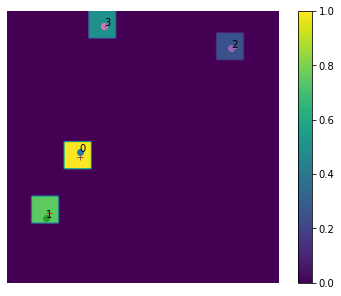

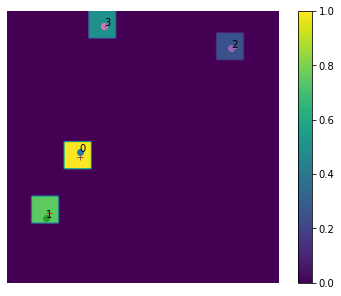

In [8]:
plt.figure(figsize=(15,5))
state_init_0 = torch.zeros(K*2,1)
cov_init_0 = 300*torch.eye(K*2)


for ims_batch, patches_batch, meas_batch, _ in test_sampler:

    meas_batch = torch.transpose(torch.squeeze(meas_batch),1,2).reshape(l,-1)
    
    # Predict permutations
    Ps,latents = sn(patches_batch.reshape(-1,K,2*patch_dim,2*patch_dim),meas_batch)
    
    # Ignore smoothing to show off data association
    sigQ = 10e3

    for P in Ps:

        # Forward-Backward RTS
        state,cov,state_pred,cov_pred,H_list = forward(P,meas_batch,state_init,cov_init,k=K,d=2,sigR=sigR,sigQ=sigQ)
        state,cov = backward(state,cov,state_pred,cov_pred,k=K,d=2)

    
    state_init = state[-1].detach().clone()
    cov_init = cov[-1].detach().clone()
    
    for idx in range(1,l):

        plt.clf()
        plt.subplot(1,2,1)
        im = torch.squeeze(ims_batch)[idx-1]
        plt.imshow(im)
        plt.colorbar()
        s = state[idx].detach().numpy()

        for j in range(K):
            plt.plot((s[j+K]),(s[j]),'o')
            plt.text((s[j+K]),(s[j]),str(j))
            plt.plot((meas_batch[idx-1][j+K]),(meas_batch[idx-1][j]),'+')
        plt.axis('off')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

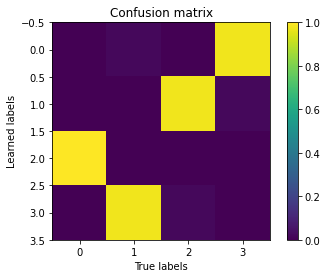

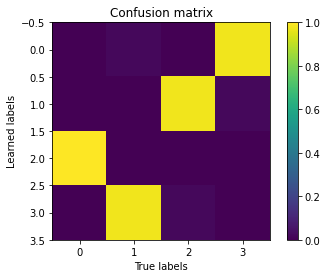

In [26]:
# Check association with true labels - ideally we should see a 1-1 mapping between learned labels and actual labels
counter = 0
acc = 0
x = np.zeros((K,K))
for ims_batch, patches_batch, meas_batch,bins_batch in test_sampler:
    
    meas_batch = torch.transpose(torch.squeeze(meas_batch),1,2).reshape(l,-1)
        
    logits,_ = sn(patches_batch.reshape(-1,K,2*patch_dim,2*patch_dim),meas_batch)
    bins_pred = torch.argmax(torch.squeeze(logits),dim=2)
    
    for i in range(bins_batch.shape[1]):
        x[bins_pred[i,:],torch.squeeze(bins_batch)[i,:]] = x[bins_pred[i,:],torch.squeeze(bins_batch)[i,:]] + 1
    
    counter += logits.shape[1]
    
    plt.clf()
    plt.imshow(x/counter)
    plt.title('Confusion matrix')
    plt.xlabel('True labels')
    plt.ylabel('Learned labels')
    plt.colorbar()
    display.clear_output(wait=True)
    display.display(plt.gcf())